In [1]:
# CORE LIBRARIES
import os
import re
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  ns

# NLP LIBRARIES
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## KERAS / TENSORFLOW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout , Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# UTILITIES
import joblib

# CONFIGURATION
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings("ignore")


2025-12-25 16:02:43.512260: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-25 16:02:43.625386: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-25 16:02:43.951399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-25 16:02:43.951485: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-25 16:02:43.972850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
# Dataset Loading and Overview

# Load all datasets
df1 = pd.read_excel("CyberBulling_Dataset_Bangla.xlsx", engine='openpyxl')
df2 = pd.read_excel("cyberbulling bangla dataset.xlsx", engine='openpyxl')
df3 = pd.read_csv("cyberbullying_tweets.csv", encoding='utf-8', encoding_errors='ignore')
df4 = pd.read_csv("romanized_bangla_bullying.csv", encoding='utf-8', on_bad_lines='skip')
# Check columns
print(df1.columns)
print(df2.columns)
print(df3.columns)
print(df4.columns)

Index(['Unnamed: 0', 'Description', 'Label'], dtype='object')
Index(['comment', 'Category', 'Gender', 'comment react number', 'label'], dtype='object')
Index(['tweet_text', 'cyberbullying_type'], dtype='object')
Index(['text', 'label'], dtype='object')


In [3]:
# Explore unique label names
print("Dataset 1 labels:", df1['Label'].unique())
print("Dataset 2 labels:", df2['label'].unique())
print("Dataset 3 labels:", df3['cyberbullying_type'].unique())
print("Dataset 4 labels:", df4['label'].unique())

Dataset 1 labels: ['sexual' 'Threat' 'Political' 'troll' 'Neutral']
Dataset 2 labels: ['religious' 'not bully' 'troll' 'sexual' 'threat']
Dataset 3 labels: ['not_cyberbullying' 'gender' 'religion' 'other_cyberbullying' 'age'
 'ethnicity']
Dataset 4 labels: ['not bullying' 'bullying']


In [4]:
# Label Normalization Function
def normalize_label(label):
    label = str(label).lower().strip()
    if label in ['neutral', 'not bully', 'not_cyberbullying', 'not bullying']:
        return 'Approved'        # Not Bullying
    else:
        return 'Not Approved'    # Bullying

# Apply normalization to each dataset
df1['final_label'] = df1['Label'].apply(normalize_label)
df2['final_label'] = df2['label'].apply(normalize_label)
df3['final_label'] = df3['cyberbullying_type'].apply(normalize_label)
df4['final_label'] = df4['label'].apply(normalize_label)   

# Check distribution
print("Dataset 1:\n", df1['final_label'].value_counts(), "\n")
print("Dataset 2:\n", df2['final_label'].value_counts(), "\n")
print("Dataset 3:\n", df3['final_label'].value_counts(), "\n")
print("Dataset 4:\n", df4['final_label'].value_counts(), "\n")   


Dataset 1:
 final_label
Not Approved    4809
Approved        1201
Name: count, dtype: int64 

Dataset 2:
 final_label
Not Approved    28661
Approved        15340
Name: count, dtype: int64 

Dataset 3:
 final_label
Not Approved    39747
Approved         7945
Name: count, dtype: int64 

Dataset 4:
 final_label
Approved        10093
Not Approved     9907
Name: count, dtype: int64 



In [5]:
# Language Filtering

# Bangla / English detector
def is_bangla(text):
    return bool(re.search('[\u0980-\u09FF]', str(text)))

def is_english(text):
    return bool(re.search('[a-zA-Z]', str(text)))

# Apply detection for df1, df2, df3
for df in [df1, df2, df3]:
    df['language'] = df['Description' if 'Description' in df.columns else 
                        'comment' if 'comment' in df.columns else 
                        'tweet_text'].apply(
        lambda x: 'BN' if is_bangla(x) else ('EN' if is_english(x) else 'OTHER')
    )

# Filter only Bangla and English for these datasets
df1 = df1[df1['language'].isin(['BN', 'EN'])]
df2 = df2[df2['language'].isin(['BN', 'EN'])]
df3 = df3[df3['language'].isin(['BN', 'EN'])]

# Manually tag Romanized Bangla dataset 
df4['language'] = 'RN'

print("Language filtering done.")

# Check Unique languages per dataset
print("Unique languages per dataset:")
print("df1:", df1['language'].unique())
print("df2:", df2['language'].unique())
print("df3:", df3['language'].unique())
print("df4:", df4['language'].unique())

Language filtering done.
Unique languages per dataset:
df1: ['BN']
df2: ['BN']
df3: ['EN']
df4: ['RN']


In [6]:
#  Dataset Merging and Column Unification

# Unify column names for each dataset
df1_final = df1[['Description', 'final_label', 'language']].rename(columns={'Description': 'text', 'final_label': 'label'})
df2_final = df2[['comment', 'final_label', 'language']].rename(columns={'comment': 'text', 'final_label': 'label'})
df3_final = df3[['tweet_text', 'final_label', 'language']].rename(columns={'tweet_text': 'text', 'final_label': 'label'})
df4_final = df4[['text', 'final_label', 'language']].rename(columns={'final_label': 'label'})   # 🔹 Romanized Bangla

# Merge all datasets together
df = pd.concat([df1_final, df2_final, df3_final, df4_final], ignore_index=True)

print(" Final merged dataset shape:", df.shape)

# Preview merged data
df.head()

 Final merged dataset shape: (117677, 3)


,text,label,language
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Not Approved,BN
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,Not Approved,BN
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,Not Approved,BN
3,বোকাচোদা একটা।,Not Approved,BN
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,Not Approved,BN


In [7]:
# Basic info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117677 entries, 0 to 117676
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      117677 non-null  object
 1   label     117677 non-null  object
 2   language  117677 non-null  object
dtypes: object(3)
memory usage: 2.7+ MB
None


In [8]:
# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
text        0
label       0
language    0
dtype: int64


In [9]:
# Duplicate check
duplicates = df.duplicated(subset='text').sum()
print("Duplicate rows:", duplicates)

Duplicate rows: 26303


In [10]:
# Remove duplicates 
df.drop_duplicates(subset='text', inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
# label distribution
print("\nLabel distribution:\n", df['label'].value_counts())


Label distribution:
 label
Not Approved    67930
Approved        23444
Name: count, dtype: int64


In [12]:
# language distribution
print("\nLanguage distribution:\n", df['language'].value_counts())


Language distribution:
 language
EN    45991
BN    45224
RN      159
Name: count, dtype: int64


In [13]:
# Empty text check
empty_rows = df[df['text'].str.strip() == ""]
print("\nEmpty text rows:", len(empty_rows))


Empty text rows: 0


In [14]:
# check dataset shape
df.shape

(91374, 3)

In [15]:
# TEXT PREPROCESSING 


# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# Stopwords

# English stopwords
stop_en = set(stopwords.words('english'))

# Bangla stopwords
try:
    stop_bn = set(stopwords.words('bengali'))
except:
    stop_bn = set()


# Romanized Bangla stopwords (dataset-specific)
stop_rn = {
    'ami', 'amra', 'tumi', 'tomra', 'se', 'tara', 'amar', 'tomar', 'tar', 'tader',
    'eta', 'ota', 'ekta', 'onek', 'sob', 'kisu', 'kichu', 'ke', 'kar', 'kare',
    'jodi', 'jodiw', 'karon', 'tai', 'ekhono', 'age', 'por', 'ekhon',
    'ar', 'kintu', 'ba', 'ta' , 'tobe', 'tore', 'nay', 'na', 'noy', 'ache', 'chilo', 'thake',
    'jonno', 'sate', 'diyese', 'bolse', 'bole', 'korse', 'korche', 'korse', 'korte',
} 


# Text Cleaning Function
def clean_text(text):
    """Clean text: remove URLs, hashtags, punctuation, normalize spaces."""
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)    # remove URLs
    text = re.sub(r'@\w+|#\w+', ' ', text)                # remove mentions, hashtags
    text = re.sub(r'[^\u0980-\u09FFA-Za-z\s]', ' ', text) # keep Bangla + English
    text = re.sub(r'\s+', ' ', text).strip()              # normalize spaces
    return text


# Preprocessing Function

stemmer = PorterStemmer()

def preprocess_text(text, lang=None):
    """Tokenize, remove stopwords for English/Bangla/Romanized, stem English."""
    text = clean_text(text)
    tokens = word_tokenize(text)
    lang = (lang or '').upper()

    if lang == 'BN':  # Bangla
        tokens = [t for t in tokens if t not in stop_bn and len(t) > 1]

    elif lang == 'EN':  # English
        tokens = [stemmer.stem(t) for t in tokens if t not in stop_en and len(t) > 2]

    elif lang == 'RN':  # Romanized Bangla
        tokens = [t for t in tokens if t not in stop_rn and len(t) > 1]

    else:  # fallback for unknown language
        tokens = [t for t in tokens if len(t) > 1]

    return ' '.join(tokens)


# Apply Preprocessing
df['clean_text'] = df.apply(lambda r: preprocess_text(r['text'], r['language']), axis=1)

# Drop empty cleaned texts
df = df[df['clean_text'].str.strip() != ''].reset_index(drop=True)

print(" Text preprocessing complete.")
print("Sample cleaned texts:\n")

df.head(10)

 Text preprocessing complete.
Sample cleaned texts:



,text,label,language,clean_text
0,ওই হালার পুত এখন কি মদ খাওয়ার সময় রাতের বেলা...,Not Approved,BN,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...
1,আপনার জন্ম প্রক্রিয়ার সময় আপনার মায়ের ভিতর কি ...,Not Approved,BN,জন্ম প্রক্রিয়ার সময় মায়ের ভিতর বাবা হুমায়ুন কব...
2,ধজভংগ দের আর ভায়াগ্রা লাগবো না। ধংস হোক এই সব ...,Not Approved,BN,ধজভংগ দের ভায়াগ্রা লাগবো ধংস কুলখানকিরা
3,বোকাচোদা একটা।,Not Approved,BN,বোকাচোদা একটা
4,তোর দেশে ফেরার অপেক্ষায় রইলাম। জেলে একটা কামরা...,Not Approved,BN,তোর দেশে ফেরার অপেক্ষায় রইলাম জেলে একটা কামরা ...
5,বাংলাদেশ ফেসবুক ইজ বিনোদন,Not Approved,BN,বাংলাদেশ ফেসবুক ইজ বিনোদন
6,ক্ষমা করার মালিক উপরওয়ালা। উনি ক্ষমা করে দিলে ...,Not Approved,BN,ক্ষমা মালিক উপরওয়ালা ক্ষমা দিলে মানুষের কিইবা ...
7,আপনি ক্ষমা চেয়েছেন। এটাই বড় কথা।ক্ষমা করার মাল...,Not Approved,BN,ক্ষমা চেয়েছেন বড় কথা ক্ষমা মালিক আল্লাহ একজন ম...
8,নিজের রিভিউ বারানোর জন্যই জতো সব নাটক? ফালতু.....,Not Approved,BN,রিভিউ বারানোর জন্যই জতো নাটক ফালতু
9,আপনাদের সকলের কাছে একটা বিষয়ে অনুরোধ-দয়াকরে এই...,Not Approved,BN,আপনাদের সকলের একটা বিষয়ে অনুরোধ দয়াকরে মহিলা ও...


In [16]:
# Save DataFrame to CSV
df.to_csv('langu_march.csv', index=False)

In [17]:
# Encode labels (Approved=0, Not Approved=1)
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

# Show mapping
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# Sanity check: balanced labels
print("\nLabel counts:\n", df['encoded_label'].value_counts())

Label mapping: {'Approved': 0, 'Not Approved': 1}

Label counts:
 encoded_label
1    67600
0    23145
Name: count, dtype: int64


In [18]:
# Train-Test Split

X = df['clean_text']
y = df['encoded_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print(f"Training samples: {len(X_train)} | Testing samples: {len(X_test)}")

Training samples: 72596 | Testing samples: 18149


In [19]:
# Tokenizer + Padding + Embedding Preparation

# Tokenizer setup
MAX_VOCAB = 30000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Tokenizer and padding completed successfully.")
print(f"Training data shape: {X_train_pad.shape}")
print(f"Testing data shape:  {X_test_pad.shape}")


Tokenizer and padding completed successfully.
Training data shape: (72596, 100)
Testing data shape:  (18149, 100)


In [ ]:

# Class Weight (Imbalance Handling)

approved_count = 23360
not_approved_count = 67895
total_samples = approved_count + not_approved_count

class_weight = {
    0: total_samples / (2 * approved_count),
    1: total_samples / (2 * not_approved_count)
}

print("Class Weights:", class_weight)

In [ ]:
# Early Stopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)


Class Weights: {0: 1.9532320205479452, 1: 0.6720303409676707}
Epoch 1/10
454/454 [==============================] - 57s 120ms/step - loss: 0.6975 - accuracy: 0.5007 - auc: 0.4983 - val_loss: 0.6908 - val_accuracy: 0.7419 - val_auc: 0.5166
Epoch 2/10
454/454 [==============================] - 54s 119ms/step - loss: 0.6925 - accuracy: 0.5158 - auc: 0.5060 - val_loss: 0.7101 - val_accuracy: 0.2561 - val_auc: 0.5006
Epoch 3/10
454/454 [==============================] - 54s 119ms/step - loss: 0.6922 - accuracy: 0.5761 - auc: 0.5009 - val_loss: 0.7104 - val_accuracy: 0.2579 - val_auc: 0.5008
Epoch 3: early stopping
568/568 [==============================] - 5s 8ms/step

Model Performance Summary
Training Accuracy   : 0.5761
Validation Accuracy : 0.2579
Test Accuracy       : 0.7449
Accuracy Difference : 0.1688

❌ Model Status: CLASS COLLAPSE

✅ Full classification report saved to 'classification_report.txt'


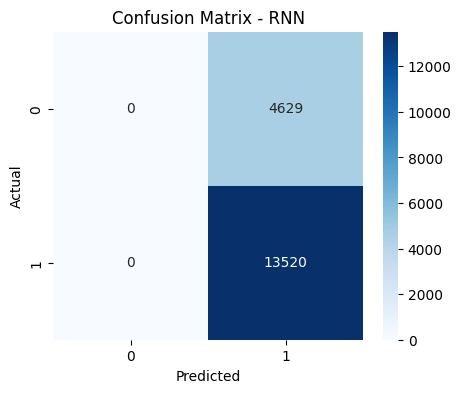

✅ Confusion matrix saved to 'confusion_matrix.csv'


In [ ]:
# Simple RNN Model

model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


# Compile Model

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'AUC']
)


# Training

history = model.fit(
    X_train_pad,
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1  # Prints only per epoch, not per batch
)


# Predictions

y_pred_prob = model.predict(X_test_pad)
THRESHOLD = 0.35
y_pred = (y_pred_prob > THRESHOLD).astype("int32")

# Accuracy Metrics

train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]
test_acc  = accuracy_score(y_test, y_pred)
acc_diff  = abs(train_acc - test_acc)

print("\n==============================")
print("Model Performance Summary")
print("==============================")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")
print(f"Test Accuracy       : {test_acc:.4f}")
print(f"Accuracy Difference : {acc_diff:.4f}")


# Correct Model Diagnosis

approved_recall = classification_report(
    y_test, y_pred, output_dict=True
)['0']['recall']

if approved_recall < 0.30:
    print("\n Model Status: CLASS COLLAPSE")
elif acc_diff <= 0.05:
    print("\n Model Status: GOOD FIT")
elif train_acc > test_acc + 0.10:
    print("\n Model Status: OVERFITTING")
else:
    print("\n Model Status: NEEDS TUNING")


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:
# ===============================
# LSTM Model
# ===============================
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    LSTM(128, dropout=0.3, recurrent_dropout=0.2),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
model.summary()

# Training
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 128)          3840000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3979905 (15.18 MB)
Trainable params: 3979905 (15.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
454

568/568 [==============================] - 33s 57ms/step

Model Performance Summary
Training Accuracy   : 0.5329
Validation Accuracy : 0.2592
Test Accuracy       : 0.7449
Accuracy Difference : 0.2120

 Model Status: CLASS COLLAPSE


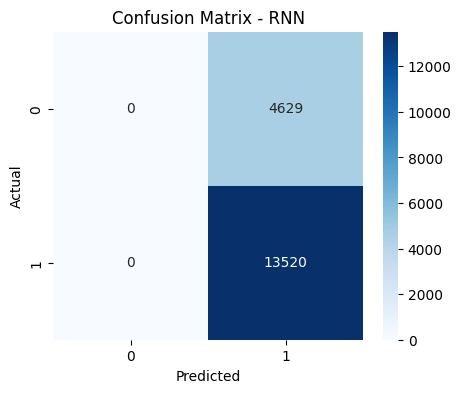

In [ ]:
# Predictions

y_pred_prob = model.predict(X_test_pad)
THRESHOLD = 0.35
y_pred = (y_pred_prob > THRESHOLD).astype("int32")

# Accuracy Metrics

train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]
test_acc  = accuracy_score(y_test, y_pred)
acc_diff  = abs(train_acc - test_acc)

print("\n==============================")
print("Model Performance Summary")
print("==============================")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")
print(f"Test Accuracy       : {test_acc:.4f}")
print(f"Accuracy Difference : {acc_diff:.4f}")


# Correct Model Diagnosis

approved_recall = classification_report(
    y_test, y_pred, output_dict=True
)['0']['recall']

if approved_recall < 0.30:
    print("\n Model Status: CLASS COLLAPSE")
elif acc_diff <= 0.05:
    print("\n Model Status: GOOD FIT")
elif train_acc > test_acc + 0.10:
    print("\n Model Status: OVERFITTING")
else:
    print("\n Model Status: NEEDS TUNING")


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - LSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



In [ ]:


# ===============================
# BiLSTM Model
# ===============================
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.2)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
model.summary()

# Training
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)


568/568 [==============================] - 15s 27ms/step

Model Performance Summary
Training Accuracy   : 0.5329
Validation Accuracy : 0.2592
Test Accuracy       : 0.7449
Accuracy Difference : 0.2120

 Model Status: CLASS COLLAPSE


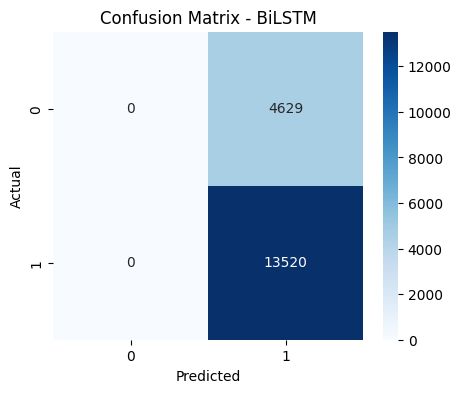

In [29]:
# Predictions

y_pred_prob = model.predict(X_test_pad)
THRESHOLD = 0.35
y_pred = (y_pred_prob > THRESHOLD).astype("int32")

# Accuracy Metrics

train_acc = history.history['accuracy'][-1]
val_acc   = history.history['val_accuracy'][-1]
test_acc  = accuracy_score(y_test, y_pred)
acc_diff  = abs(train_acc - test_acc)

print("\n==============================")
print("Model Performance Summary")
print("==============================")
print(f"Training Accuracy   : {train_acc:.4f}")
print(f"Validation Accuracy : {val_acc:.4f}")
print(f"Test Accuracy       : {test_acc:.4f}")
print(f"Accuracy Difference : {acc_diff:.4f}")


# Correct Model Diagnosis

approved_recall = classification_report(
    y_test, y_pred, output_dict=True
)['0']['recall']

if approved_recall < 0.30:
    print("\n Model Status: CLASS COLLAPSE")
elif acc_diff <= 0.05:
    print("\n Model Status: GOOD FIT")
elif train_acc > test_acc + 0.10:
    print("\n Model Status: OVERFITTING")
else:
    print("\n Model Status: NEEDS TUNING")


# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - BiLSTM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



Epoch 1/10
454/454 [==============================] - 51s 110ms/step - loss: 0.3342 - accuracy: 0.8420 - val_loss: 0.2760 - val_accuracy: 0.8709
Epoch 2/10
454/454 [==============================] - 51s 112ms/step - loss: 0.1920 - accuracy: 0.9192 - val_loss: 0.3068 - val_accuracy: 0.8674
Epoch 3/10
454/454 [==============================] - 45s 99ms/step - loss: 0.1080 - accuracy: 0.9563 - val_loss: 0.4305 - val_accuracy: 0.8656
Epoch 3: early stopping
568/568 [==============================] - 4s 7ms/step

1D CNN Test Accuracy: 0.8717

Classification Report (1D CNN):

              precision    recall  f1-score   support

    Approved       0.77      0.71      0.74      4629
Not Approved       0.90      0.93      0.91     13520

    accuracy                           0.87     18149
   macro avg       0.84      0.82      0.83     18149
weighted avg       0.87      0.87      0.87     18149



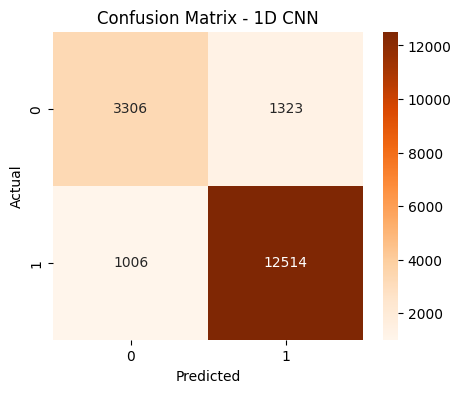

In [30]:
# 1D CNN Model

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',          # observe validation loss 
    patience=2,                  
    restore_best_weights=True,   # restore best model weight 
    verbose=1
)

# Model architecture
cnn_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_pred_cnn = (cnn_model.predict(X_test_pad) > 0.5).astype("int32")

# Test Accuracy
test_acc_cnn = accuracy_score(y_test, y_pred_cnn)
print(f"\n1D CNN Test Accuracy: {test_acc_cnn:.4f}\n")

# Classification Report
print("Classification Report (1D CNN):\n")
print(classification_report(y_test, y_pred_cnn, target_names=['Approved', 'Not Approved']))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - 1D CNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:

# ===============================
# 1D CNN Model
# ===============================
cnn_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
cnn_model.summary()

# ===============================
# Training
# ===============================
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[early_stop],
    class_weight=class_weight,
    verbose=1
)



BiLSTM and 1D CNN show the strongest performance (AUC ≈ 0.935), clearly separating classes.  
Simple RNN performs near random (AUC ≈ 0.52), while LSTM underperforms (AUC ≈ 0.50).  
Overall, **BiLSTM and 1D CNN** are the best deep models for this task.
